# Rates of Positive and Negative Words in News Articles of Different Topics

In [1]:
# Load packages
library(tidyverse)
library(dplyr)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

## Introduction

News articles are often polarizing depending on their topic of discussion making this an interesting field for analysis. Therefore, we will be using the online news popularity data set for our analysis. Each row in this dataset corresponds to one article on the Mashable website with various variables given such as the rate of positive words in the article. We aim to classify each article, published by the data source Mashable, based on which channel they would belong to - social media, lifestyle, business, or entertainment. Our predictors for this classification would be the rate of positive and negative words used in the article. Data channel type refers to the topic/theme of the article, and the global rates of positive/negative words are proportions. The question to be answered is how articles of differing topics differ in the rates of positive and negative words by using our classifier to predict article categories for future articles based on their rates of positive and negative words. 

## Preliminary Exploratory Data Analysis

In [2]:
# online URL for data
url <- 'https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip'

# creating temporary file to store zip file
temp <- tempfile()
download.file(url, temp)

# unzipping and reading in the csv file of interest
news_data <- read_csv(unz(temp, 'OnlineNewsPopularity/OnlineNewsPopularity.csv'))

# saving data table to the data file created
write_csv(news_data, 'data/news_data.csv', col_names=TRUE)

# unlinking files from temporary file created earlier
unlink(temp) 

news_data

# DESCRIPTION

# The data is relatively clean with each row containing a single observation, each column with one variable, and each cell containing only one observation. 
# The only problems are with the data channel type columns and the weekday columns. 
# These are spread out over multiple columns when they are a single variable (data channel type and weekday posted).

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,⋯,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,⋯,0.10000000,0.7,-0.3500000,-0.600,-0.2000000,0.5,-0.1875,0.0,0.1875,593
http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,731,9,255,0.6047431,1,0.7919463,3,1,1,⋯,0.03333333,0.7,-0.1187500,-0.125,-0.1000000,0.0,0.0000,0.5,0.0000,711
http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,731,9,211,0.5751295,1,0.6638655,3,1,1,⋯,0.10000000,1.0,-0.4666667,-0.800,-0.1333333,0.0,0.0000,0.5,0.0000,1500
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
http://mashable.com/2014/12/27/son-pays-off-mortgage/,8,10,442,0.5163551,1,0.6441281,24,1,12,⋯,0.1363636,0.5,-0.3564394,-0.8,-0.1666667,0.4545455,0.1363636,0.04545455,0.1363636,1900
http://mashable.com/2014/12/27/ukraine-blasts/,8,6,682,0.5394933,1,0.6926605,10,1,1,⋯,0.0625000,0.5,-0.2052455,-0.5,-0.0125000,0.0000000,0.0000000,0.50000000,0.0000000,1100
http://mashable.com/2014/12/27/youtube-channels-2015/,8,10,157,0.7019868,1,0.8461538,1,1,0,⋯,0.1000000,0.5,-0.2000000,-0.2,-0.2000000,0.3333333,0.2500000,0.16666667,0.2500000,1300


In [3]:
# making the data channel type a single variable and removing the column of 1s and 0s as it does not make any sense after
# pivot longer is applied

clean_news_data <- news_data %>%
    pivot_longer(cols = c(data_channel_is_lifestyle,
                data_channel_is_entertainment,
                data_channel_is_bus,
                data_channel_is_socmed,
                data_channel_is_tech,
                data_channel_is_world), 
                names_to = 'data_channel_type',
                values_to = 'na1') %>%

# applying the same technique as above to the weekday columns by making weekday_posted a single column with
# the 1s and 0s column removed

    pivot_longer(cols = c(weekday_is_monday,
                         weekday_is_tuesday,
                         weekday_is_wednesday,
                         weekday_is_thursday,
                         weekday_is_friday,
                         weekday_is_saturday,
                         weekday_is_sunday),
                names_to = 'weekday_posted',
                values_to = 'na2') %>%

# now we need to get rid of all of the redundant zeros that remain from the pivot longer function, 
# we only care about what the data channel type and week day posted are for each article, we do not need to know what 
# they are not (this is what the 0s are trying to convey)

    filter(na1==1 & na2==1) %>%

# data channel type is our class so we want it as a factor not a character

    mutate(data_channel_type = as_factor(data_channel_type)) %>%
    select(-na1, -na2, -is_weekend)

# there is a column named is_weekend which is redundant as we already have a the weekday_posted column 
# that tells us whether each article was posted on saturday or sunday, so after applying the pivot longer
# function, the is_weekend column does not make any sense in the data as it has 1s and 0s indicating which article
# was posted on a weekend. Therefore, it is removed

write_csv(clean_news_data, 'data/clean_news.csv', col_names=TRUE)

clean_news_data

url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,⋯,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,data_channel_type,weekday_posted
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,⋯,-0.3500000,-0.600,-0.2000000,0.5,-0.1875,0.0,0.1875,593,data_channel_is_entertainment,weekday_is_monday
http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,731,9,255,0.6047431,1,0.7919463,3,1,1,⋯,-0.1187500,-0.125,-0.1000000,0.0,0.0000,0.5,0.0000,711,data_channel_is_bus,weekday_is_monday
http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,731,9,211,0.5751295,1,0.6638655,3,1,1,⋯,-0.4666667,-0.800,-0.1333333,0.0,0.0000,0.5,0.0000,1500,data_channel_is_bus,weekday_is_monday
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
http://mashable.com/2014/12/27/seth-rogen-james-franco-will-live-tweet-the-interview/,8,12,328,0.6962963,1,0.8850575,9,7,3,⋯,-0.2111111,-0.4,-0.1000,0.3000000,1.00,0.2000000,1.00,1900,data_channel_is_socmed,weekday_is_wednesday
http://mashable.com/2014/12/27/ukraine-blasts/,8,6,682,0.5394933,1,0.6926605,10,1,1,⋯,-0.2052455,-0.5,-0.0125,0.0000000,0.00,0.5000000,0.00,1100,data_channel_is_world,weekday_is_wednesday
http://mashable.com/2014/12/27/youtube-channels-2015/,8,10,157,0.7019868,1,0.8461538,1,1,0,⋯,-0.2000000,-0.2,-0.2000,0.3333333,0.25,0.1666667,0.25,1300,data_channel_is_entertainment,weekday_is_wednesday


In [4]:
# splitting data into training and testing data using a 75/25 split with 75% training data. The data set is very large,
# so it allows us to develop the classifier on a large chunk of training data without compromising for the size of our 
# testing data since 25% of the data is still thousands of observations. Therefore a 75/25 split is suitable

set.seed(1)

news_split <- initial_split(clean_news_data, prop=0.75, strata=data_channel_type)
news_training <- training(news_split)
news_testing <- testing(news_split)

In [5]:
num_obs <- news_training %>%
    group_by(data_channel_type) %>%
    summarize(n=n())
num_obs

# DESCRIPTION

# This table is useful as it shows there is a class imbalance since the social media and lifestyle category have less observations. 
# Therefore, we will need to oversample these cases when developing our classifier to account for this disparity.

`summarise()` ungrouping output (override with `.groups` argument)



data_channel_type,n
<fct>,<int>
data_channel_is_entertainment,5301
data_channel_is_bus,4703
data_channel_is_tech,5511
data_channel_is_lifestyle,1554
data_channel_is_world,6341
data_channel_is_socmed,1725


In [6]:
predictors_avg <- news_training %>%
    select(global_rate_positive_words, global_rate_negative_words) %>%
    map_df(mean)
predictors_avg

# DESCRIPTION

# This table shows the average for the predictors we are using among all of the observations. 
# This is important information as it lets us know whether there is a drastic enough difference between the rates of positive and negative words 
# to make our classifier useful. There is quite a large difference, so our classifier should yield interesting results.

global_rate_positive_words,global_rate_negative_words
<dbl>,<dbl>
0.0398897,0.01628709


In [7]:
missing <- news_training %>%
    filter(global_rate_positive_words == 0 & global_rate_negative_words == 0) 

missing
    
# DESCRIPTION

# This table corresponds to data containing missing values as both the rate of positive and negative words is said to be 0. 
# If only one of them is 0, it could be totally possible but for both to be 0 it indicates a lack of data most likely. 
# These will have to be removed from the training set when building the classifier.

url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,⋯,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,data_channel_type,weekday_posted
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
http://mashable.com/2013/01/23/fitness-gadget-gym-cost-comparison/,715,8,0,0,0,0,0,0,0,⋯,0,0,0,0.00000000,0.00000000,0.5000000,0.00000000,1700,data_channel_is_lifestyle,weekday_is_wednesday
http://mashable.com/2013/01/25/data-vs-nature-infographic/,713,12,0,0,0,0,0,0,0,⋯,0,0,0,0.00000000,0.00000000,0.5000000,0.00000000,4500,data_channel_is_tech,weekday_is_friday
http://mashable.com/2013/01/26/infographics-marketing/,712,10,0,0,0,0,0,0,0,⋯,0,0,0,0.06666667,0.03333333,0.4333333,0.03333333,6800,data_channel_is_bus,weekday_is_saturday
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
http://mashable.com/2014/12/24/live-updates-antonio-martin-vigil/,11,10,0,0,0,0,0,0,10,⋯,0,0,0,0.5000000,0.5000000,0.00000000,0.5000000,1800,data_channel_is_lifestyle,weekday_is_sunday
http://mashable.com/2014/12/24/loyal-dog-chases-after-ambulance/,11,7,0,0,0,0,0,0,13,⋯,0,0,0,0.0000000,0.0000000,0.50000000,0.0000000,1600,data_channel_is_world,weekday_is_sunday
http://mashable.com/2014/12/26/toothpaste-fluorine-space/,9,11,0,0,0,0,0,0,21,⋯,0,0,0,0.4545455,0.1363636,0.04545455,0.1363636,5700,data_channel_is_world,weekday_is_tuesday


Joining, by = c("url", "timedelta", "n_tokens_title", "n_tokens_content", "n_unique_tokens", "n_non_stop_words", "n_non_stop_unique_tokens", "num_hrefs", "num_self_hrefs", "num_imgs", "num_videos", "average_token_length", "num_keywords", "kw_min_min", "kw_max_min", "kw_avg_min", "kw_min_max", "kw_max_max", "kw_avg_max", "kw_min_avg", "kw_max_avg", "kw_avg_avg", "self_reference_min_shares", "self_reference_max_shares", "self_reference_avg_sharess", "LDA_00", "LDA_01", "LDA_02", "LDA_03", "LDA_04", "global_subjectivity", "global_sentiment_polarity", "global_rate_positive_words", "global_rate_negative_words", "rate_positive_words", "rate_negative_words", "avg_positive_polarity", "min_positive_polarity", "max_positive_polarity", "avg_negative_polarity", "min_negative_polarity", "max_negative_polarity", "title_subjectivity", "title_sentiment_polarity", "abs_title_subjectivity", "abs_title_sentiment_polarity", "shares", "data_channel_type", "weekday_posted")

`summarise()` ungrouping output 

data_channel_type,average_rate_positive_words,average_rate_negative_words
<fct>,<dbl>,<dbl>
data_channel_is_entertainment,0.04163481,0.01951751
data_channel_is_bus,0.04327525,0.01468526
data_channel_is_tech,0.04316465,0.01448046
data_channel_is_lifestyle,0.04489091,0.01645284
data_channel_is_world,0.03223665,0.01754254
data_channel_is_socmed,0.04712154,0.01588141


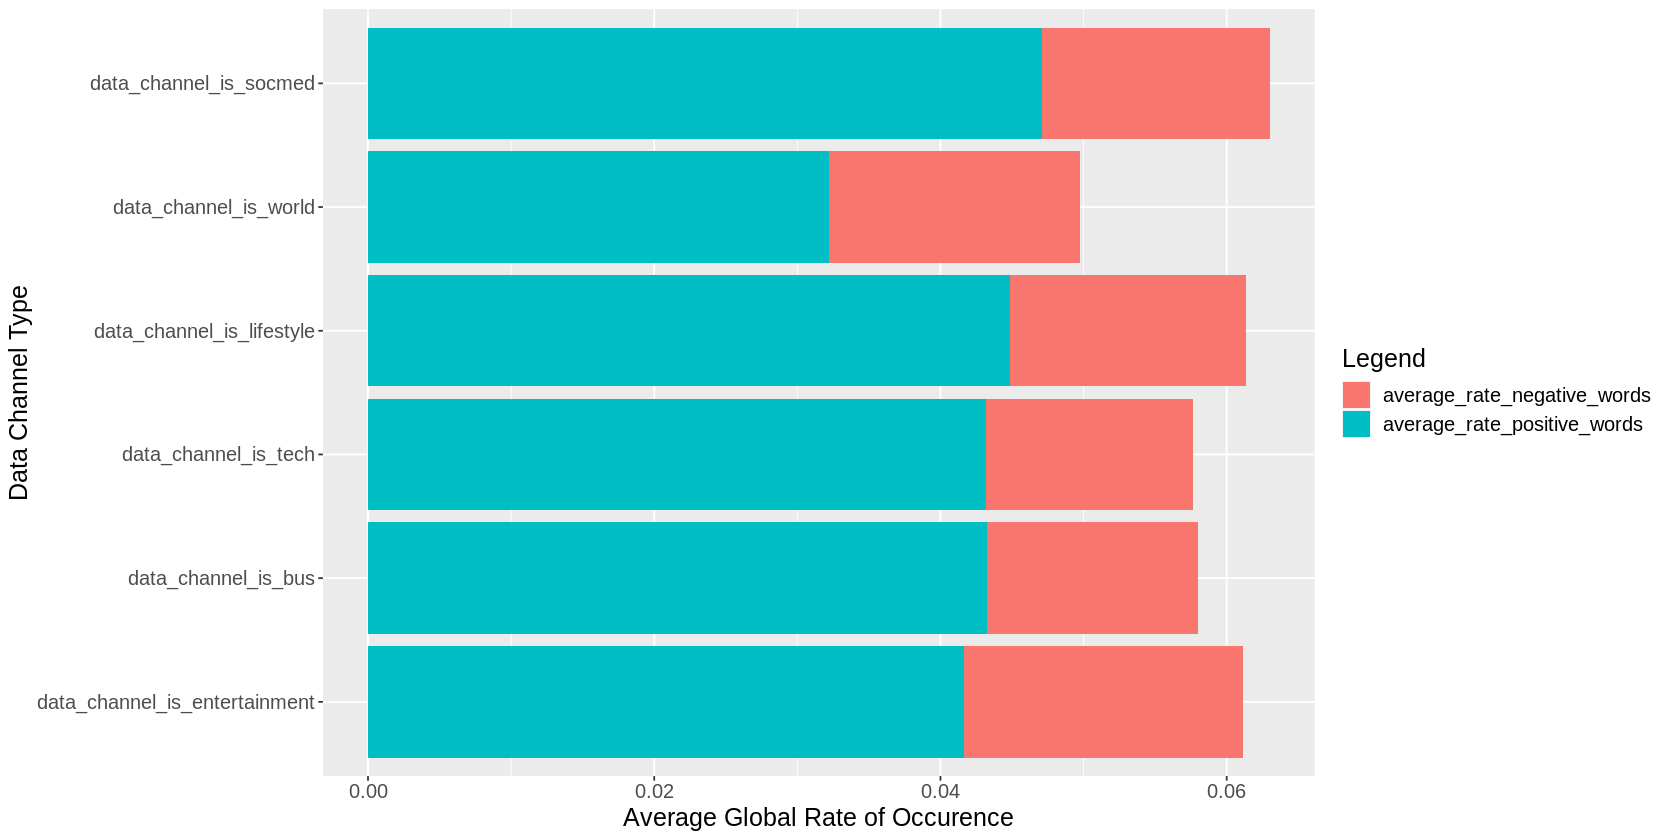

In [8]:
# excluding the rows from above that have inconclusive data
without_zeros <- news_training %>%
    anti_join(missing)

grouped_pos <- without_zeros %>%
    group_by(data_channel_type) %>%
    summarize(avg_pos = mean(global_rate_positive_words))
grouped_neg <- without_zeros %>%
    group_by(data_channel_type) %>%
    summarize(avg_neg = mean(global_rate_negative_words))
avg_together <- grouped_pos %>%
    bind_cols(grouped_neg) %>%
    select(-data_channel_type...3)
colnames(avg_together) <- c('data_channel_type', 'average_rate_positive_words', 'average_rate_negative_words')
avg_together

options(repr.plot.width = 14, repr.plot.height=7)
viz <- avg_together %>%
    gather('key', 'value', -c(data_channel_type)) %>%
    ggplot(aes(x=data_channel_type, y=value, group=key, fill=key)) +
    geom_bar(stat='identity') +
    coord_flip() +
    labs(x='Data Channel Type', y='Average Global Rate of Occurence', fill='Legend') +
    theme(text=element_text(size=15))
viz

# DESCRIPTION

# This plot shows a distribution of the average rate of both positive and negative words within each data channel category. 
# This plot guides us in predicting how our classifier should behave in classifying different data channel types from their global rates 
# of positive and negative words by providing us the average relative proportions among each group.

## Methods

- The purpose of the analysis is to predict the relationship between the global rate of positive and negative words in a news article, and the category the news channel belongs to.
- We will use the K-nearest algorithm for classification to predict the data channel type using the global rate of positive and negative words as our two predictors.
- These are good predictors as they are directly linked to the content of the articles, so it is interesting to see how these predictors differ among news articles pertaining to different topics (e.g. lifestyle versus business).
- One way we will visualize the results is creating a scatter plot from our testing data with the global positive rate of words on the x-axis and the rate of negative words on the y-axis, with the points coloured by the data channel type.

## Expected Outcomes and Significance


We anticipate that social media, entertainment, and political news would have the highest concentration of negative words, ranked respectively. Social media will have the lead due to the nature of the platform given the freedom and the lack of control. As for the positive words, we expect that tech news will be the outlier given the developments and marketing of technology in the news channels. For the rest, we believe there won’t be a disparity in the use of positive words and data points will be somewhat scattered across.

These findings could indicate whether a certain type of news is suited for juveniles. Parents could block access to these articles especially for kids who are under 10. Additionally, the analysis could be used to improve automated journalism by identifying the concentration of words and their connotations; news that doesn’t require creative writing such as tech, finance, sports, and elections are good options.

Some future questions that may arise could be how does the rate of positive or negative words in an article affect how the news is received by a specific demographic, and whether there is any difference in tolerance for readers of a specific news type compared to another.

Word Count (500)